## Анализ базы данных клиентов BetBoom

- В ходе анализа данных выявили ключевые переменные, которые оказывают наиболее значительное влияние на повторное посещение клуба и на средний размер проигрыша за посещение.
- Применили модели машинного обучения для выявления клиентов уходящих в отток.
- Применили модель, аналог RFM-score, для сегментации клиентов по вероятности повторного посещения клуба.
- Сформировали ряд гипотез по оптимизации привлечения и удержания клиентов.

## 1. Загрузка данных, библиотек и первичная предобработка

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [254]:
df = pd.read_csv('/content/drive/MyDrive/Новички_задание - Лист1 (2).csv')

In [255]:
df.columns = df.columns.str.replace(' ', '')

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83038 entries, 0 to 83037
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                83038 non-null  int64 
 1   loss_first_visit  83038 non-null  int64 
 2   in_first_visit    83038 non-null  int64 
 3   bet_with_bonus    83038 non-null  int64 
 4   deposit           83038 non-null  int64 
 5   moneywithdrawal   83038 non-null  int64 
 6   club_number       83038 non-null  object
 7   1_day             83038 non-null  object
 8   2_day             35431 non-null  object
 9   max_day           35431 non-null  object
 10  visits            83038 non-null  int64 
 11  all_losses        83038 non-null  int64 
 12  expected_losses   83038 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 8.2+ MB


In [257]:
df.max_day = pd.to_datetime(df.max_day)
df['1_day'] = pd.to_datetime(df['1_day'])
df['2_day'] = pd.to_datetime(df['2_day'])

In [258]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,id,loss_first_visit,in_first_visit,bet_with_bonus,deposit,moneywithdrawal,visits,all_losses,expected_losses
id,1.000000,-0.001533,-0.004311,0.000751,-0.012308,-0.013634,-0.005348,0.000173,-0.001815
loss_first_visit,-0.001533,1.000000,0.552611,-0.021387,0.627637,-0.298997,0.008685,0.364155,0.359541
in_first_visit,-0.004311,0.552611,1.000000,-0.013137,0.835606,0.368417,0.058251,0.466663,0.464242
bet_with_bonus,0.000751,-0.021387,-0.013137,1.000000,-0.019482,0.010646,-0.040860,-0.012071,-0.012300
deposit,-0.012308,0.627637,0.835606,-0.019482,1.000000,0.448476,0.038118,0.428266,0.438883
moneywithdrawal,-0.013634,-0.298997,0.368417,0.010646,0.448476,1.000000,0.038715,0.076033,0.088688
visits,-0.005348,0.008685,0.058251,-0.040860,0.038118,0.038715,1.000000,0.283546,0.318913
all_losses,0.000173,0.364155,0.466663,-0.012071,0.428266,0.076033,0.283546,1.000000,0.889343
expected_losses,-0.001815,0.359541,0.464242,-0.012300,0.438883,0.088688,0.318913,0.889343,1.000000


In [259]:
df = df.query('deposit < deposit.quantile(0.95)')

Отсекаем выбросы по депозиту

In [260]:
df = df.query('loss_first_visit < loss_first_visit.quantile(0.95) & loss_first_visit > loss_first_visit.quantile(0.05)')

Отсекаем выбросы по проигрышу в первый день

In [261]:
def rule(x):
    if x > 0:
         return 1
    else:
         return 0

In [262]:
def rule2(x):
    if x > 0:
         return "lose"
    if x < 0:
         return "win"     
    else:
         return "bonus_loss"

In [263]:
df['bonus'] = df.apply(lambda x: rule(x['bet_with_bonus']), axis =  1)

In [264]:
df['visits_after'] = df.apply(lambda x: rule(x['visits']), axis =  1)

In [265]:
df['money_out'] = df.apply(lambda x: rule(x['moneywithdrawal']), axis =  1)

In [266]:
df['with_deposit'] = df.apply(lambda x: rule(x['deposit']), axis =  1)

Создаем бинарные переменные для бонусов, повторных визитов, выводы средств и депозита.
- 1 - да
- 0 - нет

In [267]:
df['win_or_lose'] = df.apply(lambda x: rule2(x['loss_first_visit']), axis =  1)

Создаем категориальную переменную по победам/поражениям в первый день:
- win = выиграл
- lose = проиграл
- bonus_loss = проиграл, использяую лишь бонусы

In [268]:
df['cat_visits'] = pd.cut(df['visits'], [-1,0,1,5,10,20,30,50,999], labels=["0", "1", "2-5","6-10", "11-20", "21-30","31-50", "51+"])

In [269]:
df['cat_bonus'] = pd.cut(df['bet_with_bonus'], [-1,0,300,500,1000,2000,48001], labels=["0", "1-300", "301-500", "501-1000","1001-2000", "2000+"])

Создаем категориальные переменные для количества посещений и размера бонусов

In [270]:
df['true_visits'] = df['visits'] + 1

In [271]:
df['loss_in_visit'] = (df['all_losses'] / df['true_visits']).round().astype('int')

Считаем средний размер проигрыша за одно посещение

In [272]:
df['year'] = df['1_day'].dt.year
df['month'] = df['1_day'].dt.month

In [273]:
df['yearmonth'] = df['1_day'].dt.to_period('M')

Определяем месяц и год первого посещения

In [274]:
df.pivot_table(values=["loss_first_visit",'loss_in_visit', 'visits'], index=["month"], columns=["year"], aggfunc=['mean','count'] , fill_value = 0)

mean                            ...         count             
      loss_first_visit             loss_in_visit  ... loss_in_visit visits      
year              2020        2021          2020  ...          2021   2020  2021
month                                             ...                           
1           519.254043  331.757808    431.984501  ...          7172   1484  7172
2           481.826733  308.358312    309.063649  ...          6659   1414  6659
3           463.764433  344.551432    368.339084  ...           943   1507   943
4           494.083931  364.125546    309.679340  ...           916   1394   916
5           496.508475  338.934759    384.149718  ...           935   1416   935
6           476.367133  327.193424    506.227273  ...          1034   1430  1034
7           671.826419  286.747817    537.664483  ...           916   5496   916
8           642.778852  270.550790    501.506238  ...           886   6412   886
9           565.915636  266.370370    385.741443  ...           837   6223   837
10          482.476108  248.625253    324.582921  ...           990   7471   990
11          420.227698  270.675466    377.692893  ...           644   6838   644
12          455.407187  364.397507    364.615733  ...           722   7068   722

[12 rows x 12 columns]

Видим, что данные по первому посещению есть за еще ненаступившие даты. Пока отложим решение этого вопроса :)

## 2. Исследовательский анализ данных

In [275]:
df.sample(5)

,id,loss_first_visit,in_first_visit,bet_with_bonus,deposit,moneywithdrawal,club_number,1_day,2_day,max_day,visits,all_losses,expected_losses,bonus,visits_after,money_out,with_deposit,win_or_lose,cat_visits,cat_bonus,true_visits,loss_in_visit,year,month,yearmonth
17151,2454538802,2015,3643,0,2015,0,1650,2020-08-19,NaT,NaT,0,0,0,0,0,0,1,lose,0,0,1,0,2020,8,2020-08
9170,2442599605,3600,3600,0,3600,0,338,2020-11-26,NaT,NaT,0,0,0,0,0,0,1,lose,0,0,1,0,2020,11,2020-11
26016,2448786984,720,3960,0,720,0,1326,2020-07-23,2020-07-24,2020-07-08,3,2580,454,0,1,0,1,lose,2-5,0,4,645,2020,7,2020-07
60925,2436604930,-116,271,600,388,504,917,2020-10-17,2020-10-18,2020-10-18,1,775,864,1,1,1,1,win,1,501-1000,2,388,2020,10,2020-10
24598,2447196449,908,908,0,1200,0,1888,2020-09-10,NaT,NaT,0,0,0,0,0,0,1,lose,0,0,1,0,2020,9,2020-09


#### Количество визитов в разрезе бонусов

In [276]:
def bar (x, y, value, name):
  plt.figure(figsize=(10, 7))
  plt.grid(True)
  plt.title(name)
  plot = sns.barplot(data = df.groupby(x)[y].agg([value]).reset_index(), x = x, y = value)
  for p in plot.patches:
      plot.annotate(format(p.get_height(), '.3f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
  plt.ylabel(y)
  plt.xlabel(x)
  plt.xticks(rotation = 0)
  plt.show()

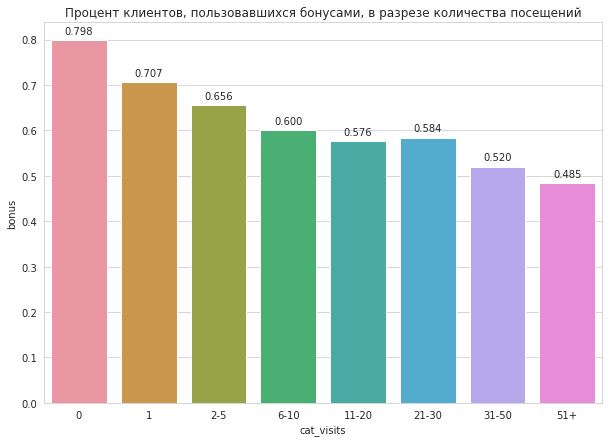

In [277]:
bar ('cat_visits', 'bonus', 'mean', 'Процент клиентов, пользовавшихся бонусами, в разрезе количества посещений')

In [278]:
df.groupby('bonus')['id'].agg('count').reset_index()

,bonus,id
0,0,18443
1,1,52364


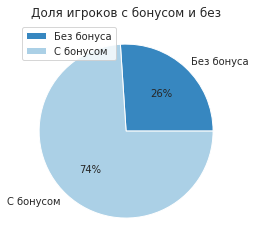

In [279]:
sns.set_style("whitegrid")
sns.set_palette('Blues_r', 2)
df.groupby('bonus')['id'].agg('count').reset_index().plot.pie(x = 'bonus', y = 'id',autopct="%.0f%%", labels=['Без бонуса','С бонусом'])
plt.title("Доля игроков с бонусом и без")
plt.xlabel(None, fontsize = 12)
plt.ylabel(None, fontsize = 12)
plt.show()

In [280]:
df.groupby('cat_bonus')[['loss_first_visit','loss_in_visit','visits_after']].agg(['mean','count'])

loss_first_visit        loss_in_visit        visits_after       
                      mean  count          mean  count         mean  count
cat_bonus                                                                 
0              1139.866508  18443    598.630808  18443     0.524264  18443
1-300           413.125096  19545    311.964902  19545     0.363981  19545
301-500         196.579534  23600    256.830551  23600     0.328517  23600
501-1000        -62.215034   8208    235.022052   8208     0.305921   8208
1001-2000      -667.048780    779    273.322208    779     0.317073    779
2000+         -1269.650862    232    395.922414    232     0.426724    232

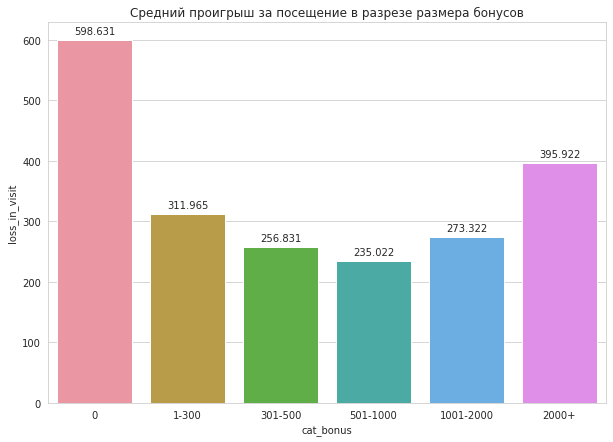

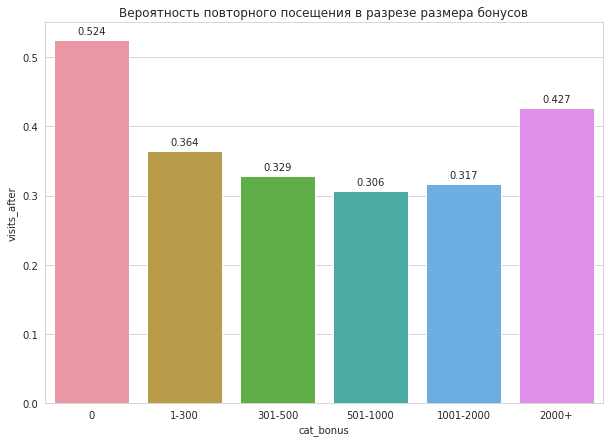

In [281]:
bar ('cat_bonus', 'loss_in_visit', 'mean', 'Средний проигрыш за посещение в разрезе размера бонусов')
bar ('cat_bonus', 'visits_after', 'mean', 'Вероятность повторного посещения в разрезе размера бонусов')

Можно сделать вывод, что бонусами пользуются преимущественно новички в беттинге.
На графике мы видим, что чем больше визитов у клиента, тем с меньшей вероятностью он пользовался бонусами при первом визите. Почти 80% клиентов, не совершивших повторного посещения, пользовались бонусами.  

**Гипотеза:** бонусы менее эффективны для привлечения опытных игроков, возможно, стоит использовать иные вовлекающие механизмы.

**Гипотеза 2:** оптимальный размер бонуса от 1 до 300. У этой категории наибольший процент повторных посещений (более 36%), самый большой средний проигрыш за одно посещение (311) и самый большой средний проигрыш в первое посещение.

#### Количество визитов в разрезе вин/луз

In [282]:
df.groupby('win_or_lose')['loss_first_visit'].agg(['mean','count'])

,mean,count
win_or_lose,,
bonus_loss,0.000000,18538
lose,1511.746905,33845
win,-1017.887538,18424


In [283]:
df.groupby('cat_visits')['loss_first_visit'].agg(['mean','count'])

,mean,count
cat_visits,,
0,342.299373,43414
1,444.202818,9368
2-5,605.013378,9568
6-10,776.076827,3202
11-20,927.932766,2350
21-30,917.214015,1056
31-50,1087.594070,978
51+,1036.721010,871


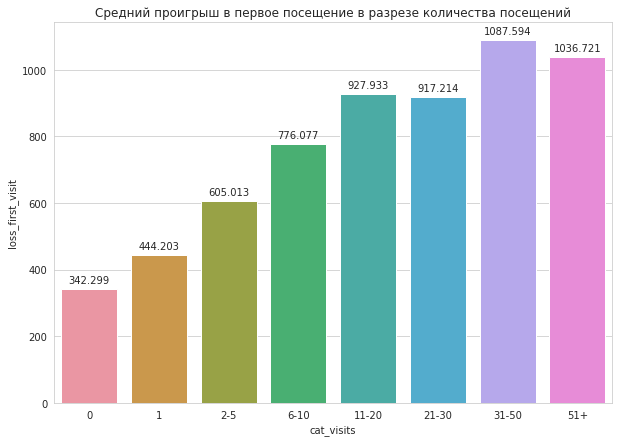

In [284]:
bar ('cat_visits', 'loss_first_visit', 'mean', 'Средний проигрыш в первое посещение в разрезе количества посещений')

In [285]:
df.groupby('cat_visits')['all_losses'].agg(['mean','count'])

,mean,count
cat_visits,,
0,-12.031534,43414
1,1051.600662,9368
2-5,3743.353052,9568
6-10,9288.156465,3202
11-20,23787.962553,2350
21-30,43447.998106,1056
31-50,73122.219836,978
51+,156515.833525,871


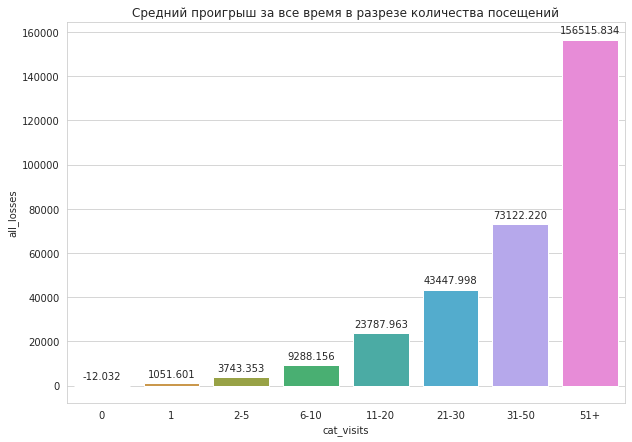

In [286]:
bar ('cat_visits', 'all_losses', 'mean', 'Средний проигрыш за все время в разрезе количества посещений')

In [287]:
df.groupby('cat_visits')['loss_in_visit'].agg(['mean','count'])

,mean,count
cat_visits,,
0,-12.031534,43414
1,525.827498,9368
2-5,923.081626,9568
6-10,1074.468457,3202
11-20,1520.310638,2350
21-30,1667.909091,1056
31-50,1795.524540,978
51+,1913.619977,871


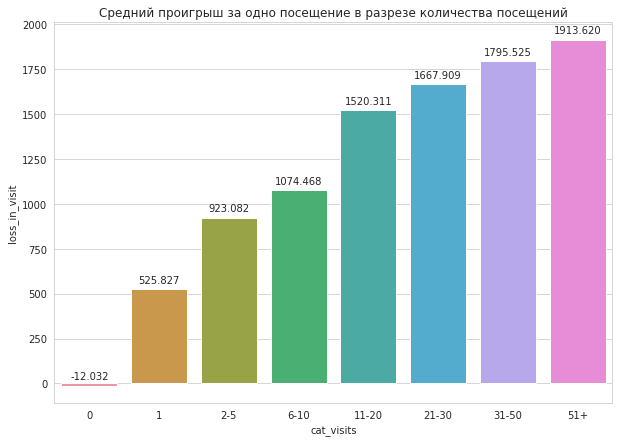

In [288]:
bar ('cat_visits', 'loss_in_visit', 'mean', 'Средний проигрыш за одно посещение в разрезе количества посещений')

In [289]:
df.groupby('with_deposit')['id'].agg('count').reset_index()

,with_deposit,id
0,0,27099
1,1,43708


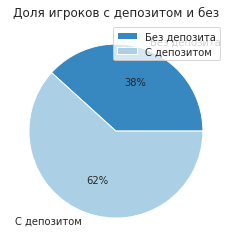

In [290]:
sns.set_style("whitegrid")
sns.set_palette('Blues_r', 2)
df.groupby('with_deposit')['id'].agg('count').reset_index().plot.pie(x = 'with_deposit', y = 'id',autopct="%.0f%%", labels=['Без депозита','С депозитом'])
plt.title("Доля игроков с депозитом и без")
plt.xlabel(None, fontsize = 12)
plt.ylabel(None, fontsize = 12)
plt.show()

In [291]:
df.query('with_deposit == 0').groupby('cat_visits')['loss_in_visit'].agg(['mean','count'])

,mean,count
cat_visits,,
0,-0.402850,21055
1,282.989444,2842
2-5,495.639540,2089
6-10,1051.461538,494
11-20,814.320988,324
21-30,661.092308,130
31-50,1153.515152,99
51+,1445.924242,66


Видим, что средний размер проигрыша за один визит растет от количества посещений. Также важно отметить, что в среднем, клиенты которые не совершают повторного визита, остаются в выигрыше (пусть и небольшом). Выигрыш можно объяснить бонусами, так как существенная часть клиентов пользуются бонусами, не внося депозит. Если рассмотреть только тех клиентов, кто при первом посещении вносил депозит - то увидим, что выигрыш среди клиентов без повторного визита существенно меньше (можно даже округлить до нуля). 

In [292]:
df.groupby('visits_after')['id'].agg('count')

visits_after
0    43414
1    27393
Name: id, dtype: int64

In [293]:
print('{:.1%}'.format((len(df.query('visits_after == 0')) / len(df))))

61.3%


In [294]:
df.groupby('cat_visits')[['all_losses', 'bonus']].agg(['mean','sum','count'])

all_losses                       bonus              
                     mean        sum  count      mean    sum  count
cat_visits                                                         
0              -12.031534    -522337  43414  0.797899  34640  43414
1             1051.600662    9851395   9368  0.707408   6627   9368
2-5           3743.353052   35816402   9568  0.655727   6274   9568
6-10          9288.156465   29740677   3202  0.600250   1922   3202
11-20        23787.962553   55901712   2350  0.575745   1353   2350
21-30        43447.998106   45881086   1056  0.584280    617   1056
31-50        73122.219836   71513531    978  0.520450    509    978
51+         156515.833525  136325291    871  0.484501    422    871

In [295]:
(len(df) * 0.61 - len(df) * 0.56) * 1051

3720907.849999991

После первого посещения отсеивается 61% клиентов. При этом эти 61% приносят суммарный убыток в 522 000. Если мы сможем улучшить конверсию в поторное посещение хотя бы на 5%, то сможем дополнительно получить, как минимум, **3 720 907** при условии сохранения среднего размера проигрыша за одно посещение.
Также видим, что почти 80% клиентов отсеявшихся при первом посещении - пользовались бонусами.

**Гипотеза:** поменять принцип работы бонусов таким образом, чтобы у клиентов была дополнительная мотивация посетить клуб во второй раз. Например, удваивать бонусы при повторном посещении.


#### Средний проигрыш в первый день в разрезе бонусов и в разрезе количества визитов

In [296]:
df.groupby('bonus')['loss_first_visit'].agg(['mean','count'])

,mean,count
bonus,,
0,1139.866508,18443
1,217.495913,52364


In [297]:
df.groupby('cat_visits')['loss_first_visit'].agg(['mean','count'])

,mean,count
cat_visits,,
0,342.299373,43414
1,444.202818,9368
2-5,605.013378,9568
6-10,776.076827,3202
11-20,927.932766,2350
21-30,917.214015,1056
31-50,1087.594070,978
51+,1036.721010,871


In [298]:
df.groupby('cat_visits')[['deposit','bet_with_bonus','loss_first_visit','loss_in_visit']].agg(['mean','count'])

deposit        bet_with_bonus  ... loss_first_visit loss_in_visit       
                   mean  count           mean  ...            count          mean  count
cat_visits                                     ...                                      
0            832.214124  43414     364.229281  ...            43414    -12.031534  43414
1           1295.322588   9368     314.650406  ...             9368    525.827498   9368
2-5         1660.253344   9568     291.266200  ...             9568    923.081626   9568
6-10        1924.718301   3202     260.585572  ...             3202   1074.468457   3202
11-20       2100.535319   2350     252.302128  ...             2350   1520.310638   2350
21-30       2251.900568   1056     251.538826  ...             1056   1667.909091   1056
31-50       2278.344581    978     243.957055  ...              978   1795.524540    978
51+         2327.117107    871     199.626866  ...              871   1913.619977    871

[8 rows x 8 columns]

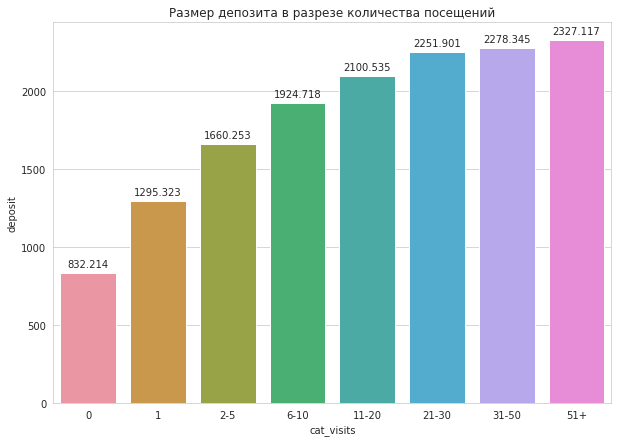

In [299]:
bar ('cat_visits', 'deposit', 'mean', 'Размер депозита в разрезе количества посещений')

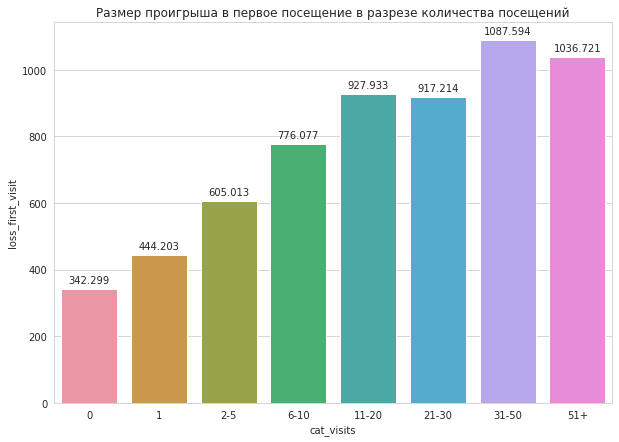

In [300]:
bar ('cat_visits', 'loss_first_visit', 'mean', 'Размер проигрыша в первое посещение в разрезе количества посещений')

In [301]:
df.groupby('visits_after')[['deposit','bet_with_bonus','loss_first_visit']].agg(['mean','count'])

deposit        bet_with_bonus        loss_first_visit       
                     mean  count           mean  count             mean  count
visits_after                                                                  
0              832.214124  43414     364.229281  43414       342.299373  43414
1             1670.216442  27393     286.199942  27393       640.708539  27393

Исходя из таблицы выше можем сделать следующие выводы: чем крупнее депозит при первом посещении, тем больше вероятность повторных посещений и чем крупнее проигрыш в первое посещение, тем также выше вероятность повторных посещений. Размер депозита и размер проигрыша достаточно сильно коррелируют между собой, поэтому, думаю, логичнее здесь будет ориентироваться именно на размер депозита. Можно предположить, что чем крупнее депозит при первом посещении - тем более опытный игрок, и тем с большей вероятностью он будет систематически возвращаться в клуб.

**Гипотеза:** для привлечения более опытных игроков с потенциально большим количеством посещений стоит реализовать бонусы напрямую связанные с размером депозита. Например, бонус в размере процента от депозита. Это может заинтересовать более опытных игроков, так как они смогут получить гораздо более существенный бонус при внесении большого депозита.

#### Выявить среднюю продолжительность между первым и вторым посещением, и определить количество дней после которых можно считать клиента ушедшим в отток

In [302]:
df['days_beetwen'] = df['2_day'] - df['1_day']

В некоторых случаях получаем отрицательное значение, по какой-то причине день второго посещения иногда предшествую первому посещению. Решение данного вопроса пока отложим :)

#### Выявить топ-клубов по доходности на одного клиента

In [303]:
df['club_number'] = df.club_number.str.partition(',')[0]

В столбце Club_number встречаются строчки, где указано сразу несколько клубов. Я предоположил, что в таком случае первый клуб в списке - это клуб первого посещения, а второй клуб в списке - клуб второго посещения. Поэтому я оставил только первый клуб в данном столбце. 

Однако это предположение оказалось не верным, ибо в некоторых случаях в строке было указано более одного номера, но второго посещения клиент не совершал.

Поэтому будем считать, что это небольшой баг и будем ориентироваться на номер первого клуба в списке.

In [304]:
clubs_count = df.groupby('club_number')['id'].agg('count').reset_index()
clubs_count = clubs_count.query('id < id.quantile(0.95) & id > id.quantile(0.05)')

In [305]:
df2 = df.query('club_number in @clubs_count.club_number')

In [306]:
clubs = df2.groupby('club_number')[['bonus', 'all_losses', 'loss_in_visit']].agg(['mean','count']).reset_index()

In [307]:
df2.groupby('club_number')['id'].count().reset_index().sort_values(by='id', ascending=False).head(5)

,club_number,id
37,1227,446
24,1175,438
157,1650,436
338,991,435
312,777,434


In [308]:
df2.groupby('club_number')['all_losses'].sum().reset_index().sort_values(by='all_losses', ascending=False).head(5)

,club_number,all_losses
133,1582,10743018
142,1610,5529669
120,1533,5346702
87,1422,4726016
105,1489,4547145


Определили топ-5 самых посещаемых клубов и топ-5 самых прибыльных.
Возможно, стоит детальнее расмотреть данные по этим клубам + запросить дополнительную информацию по всем посещениям в этом клубе, чтобы определить наиболее существенные факторы.

#### Считаем зависимость повторных посещений от отношения оборота в первый день к размеру депозита

In [309]:
df['in_vs_deposit'] = df.query('deposit > 0')['in_first_visit'] / df.query('deposit > 0')['deposit']

In [310]:
df['in_vs_deposit2'] = pd.cut(df['in_vs_deposit'], [-1,0,1,2,3,5,440], labels=["0", "1", "2", "3","4-5", "5+"])

In [311]:
df.groupby('in_vs_deposit2')[['visits_after', 'loss_in_visit', 'visits']].agg(['mean', 'count'])

visits_after        loss_in_visit           visits       
                       mean  count          mean  count      mean  count
in_vs_deposit2                                                          
0                  0.279412    544    -27.303309    544  1.522059    544
1                  0.437689  11892    253.989573  11892  4.400017  11892
2                  0.458010  12384    485.603682  12384  3.958253  12384
3                  0.497630   6330    554.146761   6330  4.743128   6330
4-5                0.547046   5941    720.039219   5941  4.991079   5941
5+                 0.592413   6617    864.157322   6617  5.984585   6617

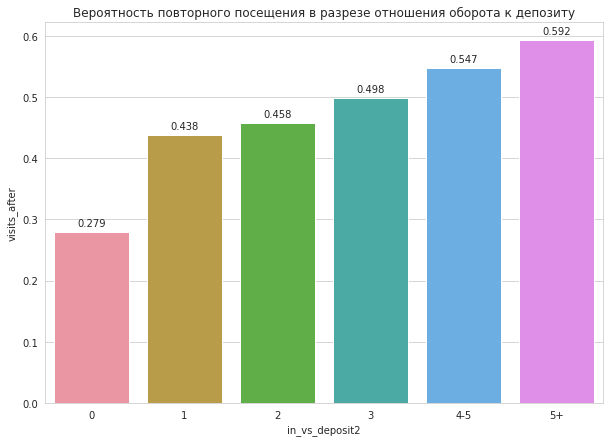

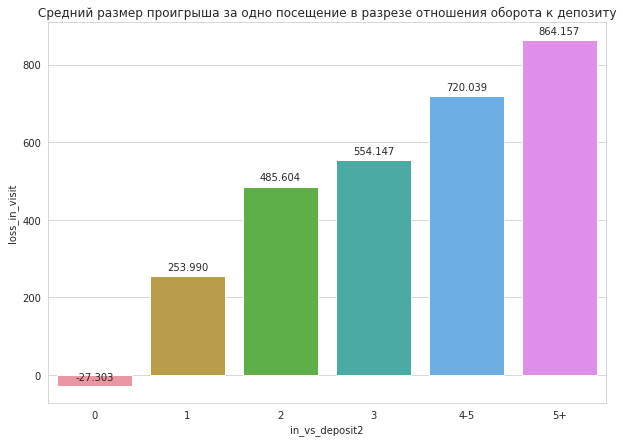

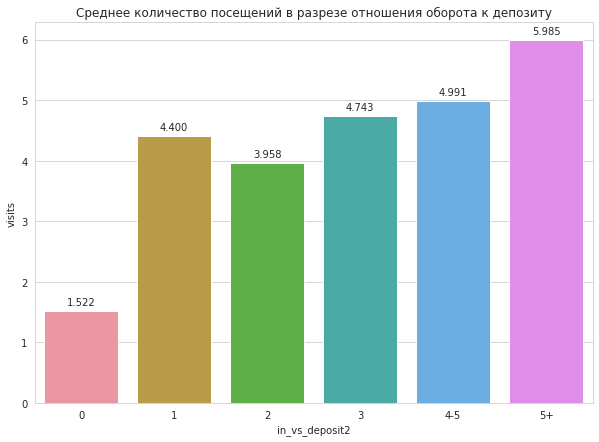

In [312]:
bar ('in_vs_deposit2', 'visits_after', 'mean', 'Вероятность повторного посещения в разрезе отношения оборота к депозиту')
bar ('in_vs_deposit2', 'loss_in_visit', 'mean', 'Средний размер проигрыша за одно посещение в разрезе отношения оборота к депозиту')
bar ('in_vs_deposit2', 'visits', 'mean', 'Среднее количество посещений в разрезе отношения оборота к депозиту')

In [313]:
df.query('bonus == 0').groupby('in_vs_deposit2')[['visits_after', 'loss_in_visit', 'visits']].agg(['mean', 'count'])

visits_after       loss_in_visit          visits      
                       mean count          mean count      mean count
in_vs_deposit2                                                       
0                       NaN     0           NaN     0       NaN     0
1                  0.470190  6793    273.573973  6793  5.219196  6793
2                  0.496940  4902    606.191554  4902  4.726642  4902
3                  0.530382  2304    660.065972  2304  5.673611  2304
4-5                0.607636  2174    942.803128  2174  6.212511  2174
5+                 0.660009  2253   1170.532623  2253  7.768309  2253

In [314]:
df.groupby('win_or_lose')[['visits_after', 'loss_in_visit']].agg(['mean', 'count'])

visits_after        loss_in_visit       
                    mean  count          mean  count
win_or_lose                                         
bonus_loss      0.216582  18538    138.833207  18538
lose            0.472507  33845    517.739902  33845
win             0.400890  18424    289.640632  18424

Видим, что победа или поражение в первое посещение не оказывают явного влияния на принятие решения о повторном посещении клуба. Среди победителей в первый день лишь 40% повторных посетителей, а среди проигравших - 47%.

Куда интереснее дела обстоят с оборотом в первый день. А точнее с тем, во сколько раз оборот в первый день превысил депозит. Чем более существенна разница между депозитом и оборотом (в пользу оборота, размеется), тем большее количество ставок клиент выиграл (либо - тем выше был коэффициент у тех ставок, где клиент угадал исход). Вероятно, именно это и оказывает решающее влияние на принятие решения о повторном посещении, а не фактор положительного или отрицательного баланса.

Так, например, у тех, у кого депозит +- равен обороту - конверсия в повторное посещение 43%. А у тех, у кого оборот превышал депозит более чем в 5 раз - конверсия 59%.

**Гипотеза:** необходимо стимулировать клиентов при первом посещении совершать большее количество ставок и создавать условия, при которых у клиентов будет больше возможностей почувствовать вкус победы. Например, делать для новых клиентов возможность поставить на событие без риска проиграть (если клиент не угадывает исход - то средства возвращаются на счет (без возможности их сразу снять) и клиент может поставить на другое событие).

In [315]:
df.groupby('money_out')[['visits_after', 'loss_in_visit','in_vs_deposit']].agg(['mean', 'count'])

visits_after        loss_in_visit        in_vs_deposit       
                  mean  count          mean  count          mean  count
money_out                                                              
0             0.372787  49358    334.240630  49358      2.895141  30401
1             0.419274  21449    416.592242  21449      3.941569  13307

In [316]:
df['in_vs_bonus'] = df.query('deposit == 0')['in_first_visit'] / df.query('deposit == 0')['bet_with_bonus']

In [317]:
df['in_vs_bonus2'] = pd.cut(df['in_vs_bonus'], [-1,0,1,2,3,5,440], labels=["0", "1", "2", "3","4-5", "5+"])

In [318]:
df.groupby('in_vs_bonus2')[['visits_after', 'loss_in_visit', 'visits']].agg(['mean', 'count'])

visits_after        loss_in_visit           visits       
                     mean  count          mean  count      mean  count
in_vs_bonus2                                                          
0                0.203345  11660     80.165009  11660  0.882075  11660
1                0.211882   9241     91.289579   9241  1.011471   9241
2                0.242791   2809    127.238519   2809  1.221787   2809
3                0.258753   1171    144.186166   1171  1.335611   1171
4-5              0.298403   1002    206.906188   1002  1.852295   1002
5+               0.351960   1199    329.557131   1199  2.403670   1199

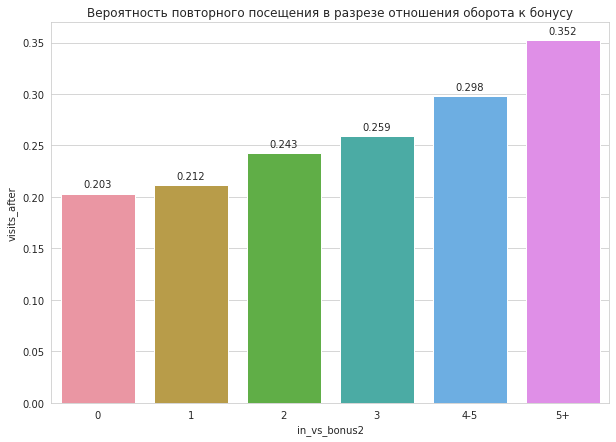

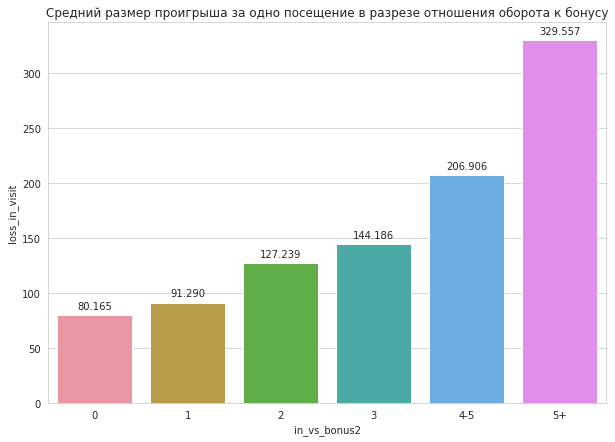

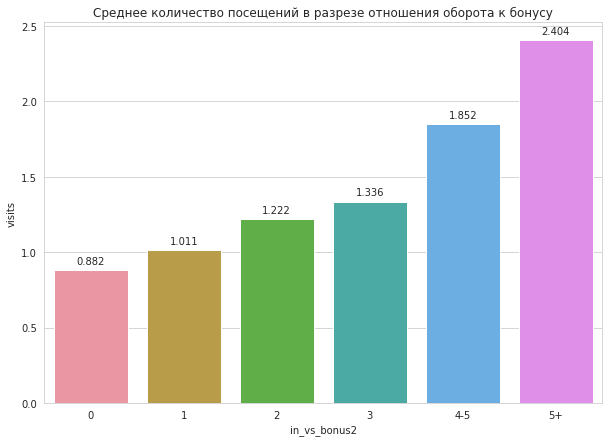

In [319]:
bar ('in_vs_bonus2', 'visits_after', 'mean', 'Вероятность повторного посещения в разрезе отношения оборота к бонусу')
bar ('in_vs_bonus2', 'loss_in_visit', 'mean', 'Средний размер проигрыша за одно посещение в разрезе отношения оборота к бонусу')
bar ('in_vs_bonus2', 'visits', 'mean', 'Среднее количество посещений в разрезе отношения оборота к бонусу')

Похожую ситуацию видим и среди тех, кто играл исключительно на бонусы при первом посещении. У тех, у кого оборот незначительно превышел размер бонуса - конверсия в повторное посещение от 21% до 24%. А вот у тех, у кого оборот превосходил размер бонуса в 4 и более раз - конверсия уже от 29% до 35%.

## 3. Немного машинного обучения для определения оттока

In [320]:
def rule3(x):
    if x == 1:
         return 0
    else:
         return 1

In [321]:
df['churn'] = df.apply(lambda x: rule3(x['visits_after']), axis =  1)

In [322]:
df_ml = df[['loss_first_visit','in_first_visit','bet_with_bonus','deposit','moneywithdrawal','club_number','month','churn']]

In [323]:
X = df_ml.drop('churn', axis=1)
y = df_ml['churn']

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [325]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [326]:
model = LogisticRegression(random_state=0, class_weight='balanced')

In [327]:
model.fit(X_train_st, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [328]:
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]

In [329]:
print('LogisticRegression')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('roc_auc: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

LogisticRegression
Accuracy: 0.67
Precision: 0.71
Recall: 0.77
F1: 0.74
roc_auc: 0.69


In [330]:
pip install catboost

In [331]:
from catboost import CatBoostClassifier, Pool

In [332]:
cat_model = CatBoostClassifier(verbose=False, random_state=0)
cat_model.fit(X_train_st, y_train)
cat_predictions = cat_model.predict(X_test_st)
cat_probabilities = cat_model.predict_proba(X_test_st)[:,1]

In [333]:
print('CatBoost')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, cat_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, cat_predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, cat_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, cat_predictions)))
print('roc_auc: {:.2f}'.format(roc_auc_score(y_test, cat_probabilities)))

CatBoost
Accuracy: 0.68
Precision: 0.70
Recall: 0.84
F1: 0.77
roc_auc: 0.72


In [334]:
rf_model = RandomForestClassifier(n_estimators = 100,random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [335]:
print('RandomForestClassifier')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('roc_auc: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))

RandomForestClassifier
Accuracy: 0.65
Precision: 0.70
Recall: 0.75
F1: 0.72
roc_auc: 0.68


In [336]:
fi_df = pd.DataFrame(data ={'feature': X.columns, 'importance': rf_model.feature_importances_})
print(fi_df.sort_values(ascending = False, by='importance'))

            feature  importance
5       club_number    0.274417
1    in_first_visit    0.217373
0  loss_first_visit    0.125038
3           deposit    0.115476
6             month    0.109449
2    bet_with_bonus    0.099619
4   moneywithdrawal    0.058629


In [337]:
fi_df = pd.DataFrame(data ={'feature': X.columns, 'importance': cat_model.feature_importances_})
print(fi_df.sort_values(ascending = False, by='importance'))

            feature  importance
5       club_number   18.143682
3           deposit   17.825861
1    in_first_visit   17.408879
0  loss_first_visit   16.715610
4   moneywithdrawal   11.260679
2    bet_with_bonus   10.589514
6             month    8.055775


У всех трех моделей примерно одинаковые показатели Accuracy и Precision. Однако Accuracy здесь учитывать не стоит, так как у нас дисбаланс классов. 

Поэтому в первую очередь будем ориентироваться на Recall. Эта метрика существенно выше у КэтБуста и равна 84. 

В данном случае Recall для нас наиболее важен, так как показывает, насколько точно мы можем определять аудиторию, которая уходит в отток. И точность равна более 80%, что весьма хорошо. 

**Гипотеза:** зная потенциально уходящую в отток аудиторию - мы сможем реализовать под нее дополнительные маркетинговые активности, которые таки заставят их прийти в клуб повторно. Например, смс-рассылку с бонусами, либо таргетированную рекламу с креативом в духе "БетБум ждет тебя! Удваиваем бонусы за повторное посещение"

Также определили фичи, которые оказывают наибольшее влияние на предсказание моделей. И в случае КэтБуста, и в случае Рандомного Леса наиболее важная фича - клуб. Далее идут оборот, депозит и размер проигрыша.

## 4. Модель сегментации по аналогии с RFM-score

Модель, которая будет сегментировать аудиторию в зависимости от вероятности повторного посещения клуба - аналог RFM-score

4х-бальная система для каждой фичи,
где 1 - самая низкая вероятность повторного посещения,
а 4 - самая высокая вероятность повторного посещещния

Фичи для оценки:
- Размер бонусов
- Отношение оборота к депозиту/бонусу
- Размер проигрыша в первый день

In [338]:
rfm = df[['id', 'loss_first_visit', 'in_first_visit', 'bet_with_bonus', 'deposit', 'visits_after']]

In [339]:
rfm['score_loss_first_visit'] = pd.cut(rfm['loss_first_visit'], [-3823,0,1000,3000,6000], labels=["1", "2", "3", "4"])

In [340]:
rfm.groupby('score_loss_first_visit')['visits_after'].agg(['mean'])

,mean
score_loss_first_visit,
1,0.308452
2,0.428127
3,0.496558
4,0.551825


In [341]:
rfm['score_bonus'] = pd.cut(rfm['bet_with_bonus'], [-1,0,300,700,25000], labels=["4", "3", "2", "1"])

In [342]:
rfm.groupby('score_bonus')['visits_after'].agg(['mean','count'])

,mean,count
score_bonus,,
4,0.524264,18443
3,0.363981,19545
2,0.323980,27977
1,0.319290,4842


In [343]:
rfm['deposit_vs_in'] = rfm.query('deposit > 0')['in_first_visit'] / rfm.query('deposit > 0')['deposit']

In [344]:
rfm['bonus_vs_in'] = rfm.query('deposit == 0')['in_first_visit'] / rfm.query('deposit == 0')['bet_with_bonus']

In [345]:
rfm['deposit_bonus_vs_in'] = rfm['deposit_vs_in'].combine_first(rfm['bonus_vs_in'])

In [346]:
rfm = rfm.query('deposit_bonus_vs_in != deposit_bonus_vs_in.max()')

In [347]:
rfm['score_in'] = pd.cut(rfm['deposit_bonus_vs_in'], [-1,0,2,5,500], labels=["1", "2", "3", "4"])

In [348]:
rfm.groupby('score_in')['visits_after'].agg(['mean','count'])

,mean,count
score_in,,
1,0.206735,12204
2,0.372103,36326
3,0.484769,14444
4,0.555527,7816


In [349]:
rfm_final = rfm[['id','score_bonus', 'score_loss_first_visit','score_in', 'loss_first_visit','visits_after']]

In [350]:
rfm_final = rfm_final.dropna()

In [351]:
rfm_final['score_bonus'] = rfm_final['score_bonus'].astype('int')
rfm_final['score_loss_first_visit'] = rfm_final['score_loss_first_visit'].astype('int')
rfm_final['score_in'] = rfm_final['score_in'].astype('int')

In [352]:
rfm_final['final_score'] = rfm_final['score_bonus'] + rfm_final['score_loss_first_visit'] + rfm_final['score_in']

In [353]:
rfm_final.groupby('final_score')[['visits_after','loss_first_visit']].agg(['count','mean'])

visits_after           loss_first_visit             
                   count      mean            count         mean
final_score                                                     
3                   1047  0.185291             1047  -752.040115
4                   7916  0.199217             7916  -421.432163
5                  14851  0.255942            14851  -284.042893
6                   9258  0.341110             9258  -171.974076
7                  10435  0.453091            10435   121.550168
8                  12054  0.474199            12054   740.030529
9                   8677  0.510430             8677  1529.103492
10                  4464  0.547491             4464  2668.625224
11                  1711  0.635885             1711  3186.707189
12                   377  0.660477              377  4078.657825

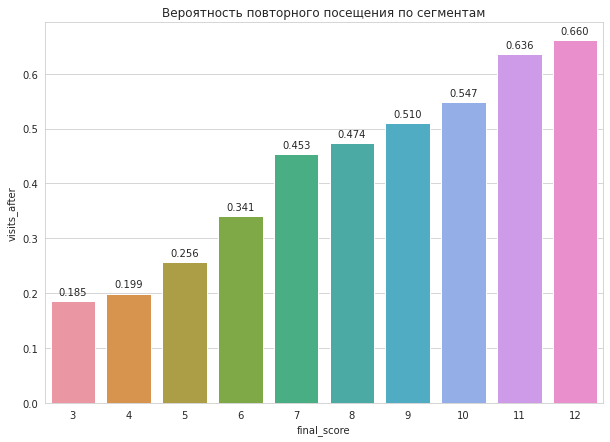

In [354]:
plt.figure(figsize=(10, 7))
plt.grid(True)
plt.title('Вероятность повторного посещения по сегментам')
plot = sns.barplot(data = rfm_final.groupby('final_score')['visits_after'].agg(['mean']).reset_index(), x = 'final_score', y = 'mean')
for p in plot.patches:
        plot.annotate(format(p.get_height(), '.3f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', va = 'center', 
                      xytext = (0, 9), 
                      textcoords = 'offset points')
plt.ylabel('visits_after')
plt.xlabel('final_score')
plt.xticks(rotation = 0)
plt.show()

Видим, что сегментация прошла успешно и наблюдается рост процента повторных посещений от сегмента к сегменту.

Какждый сегмент можно более детально проанализировать и выявить более специфические характеристики. Однако уже и в таком виде модель пригодна для использования. Под каждый сегмент (или под группы сегментов) можно реализовать индивидуальные маркетинговые активности.

Так, например, группа сегментов 10-12 - это, вероятно, более опытные игроки, которые в большинстве своем и без дополнительной стимуляции посетят клуба повторно. Поэтому под них можно реализовать бонус зависящий от размера депозита.

А вот сегменты 3-5 с большой вероятностью уйдут в отток, поэтому их, например, есть смысл помучать большим количеством касаний в таргетированной рекламе и смс-рассылках с бонусами на повторное посещение.